# 4. Long-Horizon Forecast

Long-horizon forecasting is challenging because of the *volatility* of the predictions and the *computational complexity*. To solve this problem we created the [N-HiTS](https://arxiv.org/abs/2201.12886) model and made the code available [NeuralForecast library](https://nixtla.github.io/neuralforecast/models.nhits.html). 

N-HiTS specializes its partial outputs in the different frequencies of the time series through hierarchical interpolation and multi-rate input
processing. 

In this notebook we show how to use N-HiTS on the [ETTm2](https://github.com/zhouhaoyi/ETDataset) benchmark dataset. This data set includes data points for 2 Electricity Transformers at 2 stations, including load, oil temperature.

We will show you how to load data, train, and perform automatic hyperparameter tuning, **to achieve SoTA performance**, outperforming even the latest Transformer architectures for a fraction of their computational cost (50x faster).

Table of Contents
1.   Installing NeuralForecast Library
2.   Load ETTm2 Data
3.   Define Hyperparameter Space
4.   Hyperparameter Tuning
5.   Evaluate Results

You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/LongHorizon_with_NHITS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing Neuralforecast library

In [ ]:
%%capture
!pip install neuralforecast datasetsforecast

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ray import tune

from neuralforecast.auto import AutoNHITS
from neuralforecast.core import NeuralForecast

from neuralforecast.losses.pytorch import MAE
from neuralforecast.losses.numpy import mae, mse
from datasetsforecast.long_horizon import LongHorizon

In [ ]:
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

This example will automatically run on GPUs if available. **Make sure** cuda is available. (If you need help to put this into production send us an email or join or community, we also offer a fully hosted solution)

In [ ]:
torch.cuda.is_available()

True

## 2. Load ETTm2 Data

The `LongHorizon` class will automatically download the complete ETTm2 dataset and process it.

It return three Dataframes: `Y_df` contains the values for the target variables, `X_df` contains exogenous calendar features and `S_df` contains static features for each time-series (none for ETTm2). For this example we will only use `Y_df`.

If you want to use your own data just replace `Y_df`. Be sure to use a long format and have a simmilar structure than our data set.

In [ ]:
# Change this to your own data to try the model
Y_df, _, _ = LongHorizon.load(directory='./', group='ETTm2')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

# For this excercise we are going to take 20% of the DataSet
n_time = len(Y_df.ds.unique())
val_size = int(.2 * n_time)
test_size = int(.2 * n_time)

Y_df.groupby('unique_id').head(2)

,unique_id,ds,y
0,HUFL,2016-07-01 00:00:00,-0.041413
1,HUFL,2016-07-01 00:15:00,-0.185467
57600,HULL,2016-07-01 00:00:00,0.040104
57601,HULL,2016-07-01 00:15:00,-0.214450
115200,LUFL,2016-07-01 00:00:00,0.695804
115201,LUFL,2016-07-01 00:15:00,0.434685
172800,LULL,2016-07-01 00:00:00,0.434430
172801,LULL,2016-07-01 00:15:00,0.428168
230400,MUFL,2016-07-01 00:00:00,-0.599211
230401,MUFL,2016-07-01 00:15:00,-0.658068


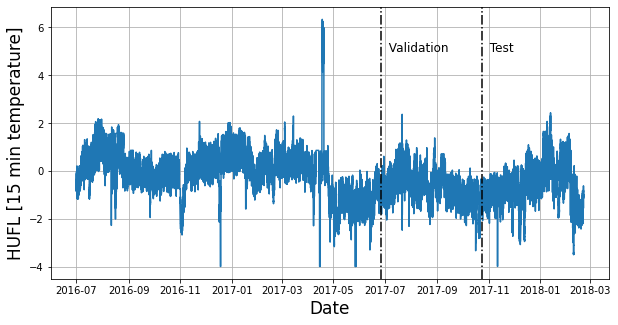

In [ ]:
# We are going to plot the temperature of the transformer 
# and marking the validation and train splits
u_id = 'HUFL'
x_plot = pd.to_datetime(Y_df[Y_df.unique_id==u_id].ds)
y_plot = Y_df[Y_df.unique_id==u_id].y.values

x_val = x_plot[n_time - val_size - test_size]
x_test = x_plot[n_time - test_size]

fig = plt.figure(figsize=(10, 5))
fig.tight_layout()

plt.plot(x_plot, y_plot)
plt.xlabel('Date', fontsize=17)
plt.ylabel('HUFL [15 min temperature]', fontsize=17)

plt.axvline(x_val, color='black', linestyle='-.')
plt.axvline(x_test, color='black', linestyle='-.')
plt.text(x_val, 5, '  Validation', fontsize=12)
plt.text(x_test, 5, '  Test', fontsize=12)

plt.grid()
plt.show()
plt.close()

In [ ]:
Y_df.unique_id.unique()

array(['HUFL', 'HULL', 'LUFL', 'LULL', 'MUFL', 'MULL', 'OT'], dtype=object)

## 3. Define Hyperparameter Space

The `AutoNHITS` class contains a pre-defined suggested hyperparameter space, built for the [Hyperopt library](https://iopscience.iop.org/article/10.1088/1749-4699/8/1/014008/meta).  This function only needs dataframe specific information such as the number of series and frequency. Feel free to play around with this space.

The parameter `h` is used to specify the desired forecasting horizon. To replicate results for other horizons from the paper, just change this value!

The  `AutoNHITS.default_config` attribute contains a suggested hyperparameter space. Here we send the paper's config.

In [ ]:
horizon = 96 # 24hrs = 4 * 15 min.

# Use your own config or AutoNHITS.default_config
nhits_config = {
       "learning_rate": tune.choice([1e-3]),                                     # Initial Learning rate
       "max_steps": tune.choice([1000]),                                         # Number of SGD steps
       "input_size": tune.choice([5 * horizon]),                                 # input_size = multiplier * horizon
       "batch_size": tune.choice([7]),                                           # Number of series in windows
       "windows_batch_size": tune.choice([256]),                                 # Number of windows in batch
       "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),               # MaxPool's Kernelsize
       "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]]), # Interpolation expressivity ratios
       "activation": tune.choice(['ReLU']),                                      # Type of non-linear activation
       "n_blocks":  tune.choice([[1, 1, 1]]),                                    # Blocks per each 3 stacks
       "mlp_units":  tune.choice([[[512, 512], [512, 512], [512, 512]]]),        # 2 512-Layers per block for each stack
       "interpolation_mode": tune.choice(['linear']),                            # Type of multi-step interpolation
       "random_seed": tune.randint(1, 10),
    }

You can override the NHiTS `config` for each hyperparameter.

Notice that *1000 Stochastic Gradient Steps* are enough to achieve SoTA performance.

Refer to http://hyperopt.github.io/hyperopt/ for more information on the different space options, such as lists and continous intervals.m

# 4. Hyperparameter Tuning

The function hyperopt_tunning will perform the automatic hyperparameter optimization using the Hyperopt library for any of our implemented models, on the specified space, on any dataframes Y_df and with custom validation and test losses.

This function will split the data in Y_df based on the number of timestamps for the validation and test sets, specified with ds_in_val and ds_in_test. Each configuration will be trained on the train split, evaluated on the validation and test sets with the desired loss functions.

Use the hyperopt_max_evals parameter to change the number of configurations explored (5 is enough for achieving SoTA performance, but more iterations will further improve results).

In [ ]:
%%capture
# Fit and predict
fcst = NeuralForecast(
    models=[AutoNHITS(h=horizon, config=nhits_config, 
                      num_samples=5)], # control of hyperopt samples
    freq='15min')

fcst_df = fcst.cross_validation(df=Y_df, val_size=val_size,
                                test_size=test_size, n_windows=None)

## 5. Evaluate Results


The `AutoNHITS` class contains a `.results` tune attribute. For each configuration explored, with information of the hyperparameter optimization. 
It contains the validation loss, and best validation hyperparameter.

In [ ]:
fcst.models[0].results.get_best_result().config

{'learning_rate': 0.001,
 'max_steps': 1000,
 'input_size': 480,
 'batch_size': 7,
 'windows_batch_size': 256,
 'n_pool_kernel_size': [2, 2, 2],
 'n_freq_downsample': [168, 24, 1],
 'activation': 'ReLU',
 'n_blocks': [1, 1, 1],
 'mlp_units': [[512, 512], [512, 512], [512, 512]],
 'interpolation_mode': 'linear',
 'random_seed': 1,
 'h': 96}

In [ ]:
y_true = fcst_df.y.values
y_hat = fcst_df['AutoNHITS'].values

n_series = len(Y_df.unique_id.unique())

y_true = y_true.reshape(n_series, -1, horizon)
y_hat = y_hat.reshape(n_series, -1, horizon)

print('Parsed results')
print('2. y_true.shape (n_series, n_windows, n_time_out):\t', y_true.shape)
print('2. y_hat.shape  (n_series, n_windows, n_time_out):\t', y_hat.shape)

Parsed results
2. y_true.shape (n_series, n_windows, n_time_out):	 (7, 11425, 96)
2. y_hat.shape  (n_series, n_windows, n_time_out):	 (7, 11425, 96)


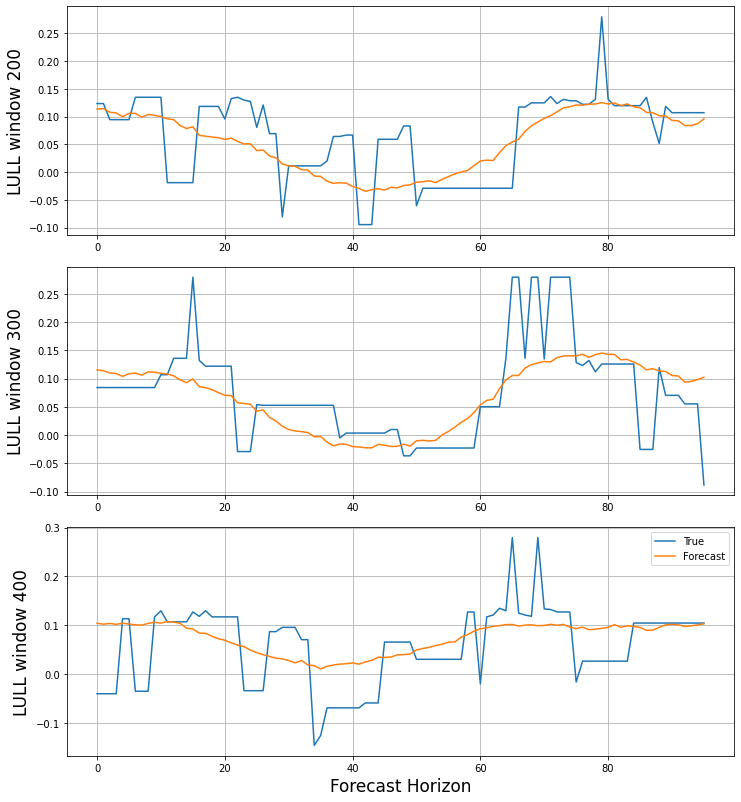

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 11))
fig.tight_layout()

series = ['HUFL','HULL','LUFL','LULL','MUFL','MULL','OT']
series_idx = 3

for idx, w_idx in enumerate([200, 300, 400]):
  axs[idx].plot(y_true[series_idx, w_idx,:],label='True')
  axs[idx].plot(y_hat[series_idx, w_idx,:],label='Forecast')
  axs[idx].grid()
  axs[idx].set_ylabel(series[series_idx]+f' window {w_idx}', 
                      fontsize=17)
  if idx==2:
    axs[idx].set_xlabel('Forecast Horizon', fontsize=17)
plt.legend()
plt.show()
plt.close()

Finally, we compute the test errors for the two metrics of interest (which are also available in the `trials` object):

$\qquad MAE = \frac{1}{Windows * Horizon} \sum_{\tau} |y_{\tau} - \hat{y}_{\tau}| \qquad$ and $\qquad MSE = \frac{1}{Windows * Horizon} \sum_{\tau} (y_{\tau} - \hat{y}_{\tau})^{2} \qquad$

In [ ]:
print('MAE: ', mae(y_hat, y_true))
print('MSE: ', mse(y_hat, y_true))

MAE:  0.264508916686362
MSE:  0.19353899829479543


For reference we can check the performance when compared
to previous 'state-of-the-art' long-horizon Transformer-based forecasting methods from the [N-HiTS paper](https://arxiv.org/abs/2201.12886). To recover or improve the paper results try setting `hyperopt_max_evals=30` in [Hyperparameter Tuning](#cell-4).

Mean Absolute Error (MAE):

| Horizon   | N-HiTS       | AutoFormer | InFormer | ARIMA 
|---        |---           |---         |---       |---
|  96       |  **0.255**     |   0.339    |  0.453   | 0.301 
|  192      |  0.305       |   0.340    |  0.563   | 0.345 
|  336      |  0.346       |   0.372    |  0.887   | 0.386 
|  720      |  0.426       |   0.419    |  1.388   | 0.445 

Mean Squared Error (MSE):

| Horizon   | N-HiTS       | AutoFormer | InFormer | ARIMA 
|---        |---           |---         |---       |---
|  96       |  **0.176**     |   0.255    |  0.365   | 0.225 
|  192      |  0.245       |   0.281    |  0.533   | 0.298 
|  336      |  0.295       |   0.339    |  1.363   | 0.370 
|  720      |  0.401       |   0.422    |  3.379   | 0.478 